In [4]:
################################################################################
# Description: Format micro sample data in two formats:
#   1. samples' attributes are categories (for Multi-level IPU)
#   2. samples with all attributes to be scaled (synthesied based on its weight)
################################################################################
import pandas as pd
import csv
import re
import numpy as np
import math
import matplotlib

# inputFile = 'baltimore_ind_samples.csv'
inputFile = 'Population_data/baltimore_samples_2018_apr30.csv'
outputFolder = 'Processing_data/samples/'
# for generating population with all attributes
sampleAttFile = outputFolder + 'samples_with_all_attributes.csv'
multilevelSampleFile = outputFolder + 'samples.dat'
df = pd.read_csv(inputFile)
df_samples = pd.DataFrame()

# Sample header: YEAR,DATANUM,SERIAL,HHWT,COUNTY,MET2013,CITYPOP,PUMA,CPUMA0010,GQ,OWNERSHP,OWNERSHPD,HHINCOME,PERNUM,PERWT,FAMSIZE,SEX,AGE,EDUC,EDUCD,EMPSTAT,EMPSTATD,LABFORCE,OCC,TRANWORK
print(df.columns)
df['EDUCD'].unique()

Index([u'YEAR', u'DATANUM', u'SERIAL', u'HHWT', u'COUNTY', u'MET2013',
       u'CITYPOP', u'PUMA', u'CPUMA0010', u'GQ', u'OWNERSHP', u'OWNERSHPD',
       u'HHINCOME', u'VEHICLES', u'PERNUM', u'PERWT', u'FAMSIZE', u'RELATE',
       u'RELATED', u'SEX', u'AGE', u'SCHOOL', u'EDUC', u'EDUCD', u'EMPSTAT',
       u'EMPSTATD', u'LABFORCE', u'OCC', u'INCTOT', u'INCWAGE', u'INCEARN',
       u'TRANWORK', u'TRANTIME', u'DEPARTS', u'ARRIVES'],
      dtype='object')


array([ 64, 101,  14,   2,   1,  23,  63,  71,  81,  26,  11,  12, 116,
       114, 115,  40,  50,  16,  17,  15,  65,  30,  25,  22,  61])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10c19d410>]],
      dtype=object)

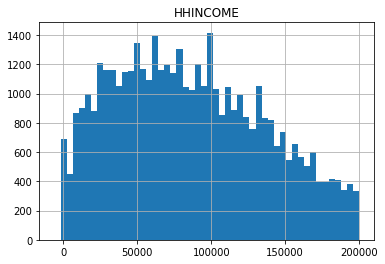

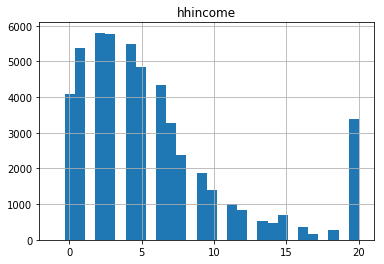

In [47]:
%matplotlib inline

lower_hhincome = df[df['HHINCOME'] < 200000]
# lower_hhincome['HHINCOME'] = lower_hhincome.apply(lambda r: r.HHINCOME/12, axis=1)
lower_hhincome.hist(column='HHINCOME', bins=50)
# df['HHINCOME'].unique()
# df['HHINCOME']
# df['HHINCOME'].bar()


def mapHHIncome(income):
    # category: 20, 40, 60 --> 300, 350, 400, 450, 500
    income = income // 1000
    if income < 300: # 15 categories
        return income // 20
    elif income < 500: # 19 categories
        income = income - 300
        return 15 + income // 50
    elif income < 1000: # 
        income = income - 500
        return 19 + income //100
    return 25
    
df_samples['hhincome'] = df['HHINCOME'].map(mapHHIncome)
df_samples.hist(column='hhincome', bins=30)


In [3]:
df['EDUCD"'].unique()

KeyError: 'EDUCD"'

In [ ]:
# IPUMS (category checks)
# familysize 1->29
# sex (male-1, female 2)
# age (0-135)
# educ (0-11)

# ACS (category)
# age
# gender
# hhsize
# vehicles
################## AGE (IPUMS) to age (ACS) categories #####################
age_category = [' - Under 5 years', ' - 5 to 9 years', ' - 10 to 14 years', ' - 15 to 17 years', ' - 18 and 19 years', ' - 20 years', ' - 21 years',
' - 22 to 24 years', ' - 25 to 29 years', ' - 30 to 34 years', ' - 35 to 39 years', ' - 40 to 44 years', ' - 45 to 49 years', ' - 50 to 54 years',
' - 55 to 59 years', ' - 60 and 61 years', ' - 62 to 64 years', ' - 65 and 66 years', ' - 67 to 69 years', ' - 70 to 74 years', ' - 75 to 79 years',
' - 80 to 84 years', ' - 85 years and over']

ranges = [(0, 4)]
for i in range(1, len(age_category)-1):
    from_to = age_category[i][3:].split(' ')
    from_age = from_to[0]
    if len(from_to) < 3:
        to_age = from_age
    else:
        to_age = from_to[2]
    ranges.append( (int(from_age), int(to_age)) )
ranges.append( (85, float("inf")))

def get_age_category(age):
    for i in range(len(ranges)):
        if ranges[i][0] <= age and age <= ranges[i][1]:
            return i

df_samples['age'] = df['AGE'].map(get_age_category)

################## SEX (IPUMS) to gender (ACS) categories #####################
# IPUM sex (male-1, female 2) ACS {'0': ' Male', '1': ' Female'}
df_samples['gender'] = df['SEX'].map(lambda gender: gender - 1)

################## vehicles per household #####################
def mapVehicles(category):
    if category == 0 or category==9:
        return 0
    elif category >= 4:
        return 4
    return category

df_samples['vehicles'] = df['VEHICLES'].map(mapVehicles)
################## people per household #####################
df_samples['educ'] = df['EDUC']
print(df['EDUC'].unique())  #df['SEX'].map(lambda gender: gender - 1)
# 00		N/A or no schooling
# 01		Nursery school to grade 4
# 02		Grade 5, 6, 7, or 8
# 03		Grade 9
# 04		Grade 10
# 05		Grade 11
# 06		Grade 12
# 07		1 year of college
# 08		2 years of college
# 09		3 years of college
# 10		4 years of college
# 11		5+ years of college

################## household_id ##########################
df_samples['hhid'] = df['YEAR']*10**10 + df['DATANUM']*10*8 + df['SERIAL']

################## individual_id ########################
df_samples['indid'] = df_samples['hhid'] * 100 + df['PERNUM']

################## people per household #####################
# Check each household has the right number of individuals (APER)
# print(type(samples['hhid'].value_counts()))
# df_samples['APER'] =  df['FAMSIZE'] # not matching to counts sometimes!!
counts = df_samples['hhid'].value_counts()
df_samples['APER'] = df_samples['hhid'].map(lambda hhid: counts[hhid])

# for index, row in samples.iterrows():
#     if counts[row.hhid] != row.APER:
#         row.APER = counts[row.hhid]
#         print(int(row.hhid))
#         print(row.hhid,  counts[row.hhid], row.APER, row)
#         break
#         wrong +=1
#     else:
#         right +=1
# print('wrong r', wrong, right)

#####
# Baltimore has unique 23001 households
# unique people
# serial (household unique): Each record contains a serial number which links the persons in the housing unit to the appropriate household record.
# PERNM (indiv unique) in the household
# YEAR, DATANUM, and SERIAL provides a unique identifier for every household in the IPUMS;
# YEAR, DATANUM, SERIAL, and PERNUM uniquely identifies every person in the database.

######## Houshold income ######
df_samples['hh_income'] = df['HHINCOME']
df['TRANWORK']


######## Write  RS samples  ###,
df_samples['school'] = df['SCHOOL']
df_samples['employment'] = df['EMPSTAT']
df_samples['income_earn'] = df['INCEARN']

df_samples = df_samples.sort_values(['hhid'])
df_samples[['hhid', 'indid', 'APER', 'gender', 'age', 'educ', 'vehicles']].to_csv(multilevelSampleFile, index=False, sep=' ')
df_samples.to_csv(sampleAttFile, index=False)

print('num of samples: ', len(df_samples.index))
################## Write individuals' vars #####################
df_ind = pd.DataFrame()
df_ind = df_samples.educ.value_counts()
df_ind.rename('N', inplace=True)
# print(type(df_ind.educ.value_counts()))
df_ind.to_csv(indFile, index_label='educ', sep=' ',  header=True)
